In [379]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from model import Autoencoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [380]:

train_X = pd.read_csv("data/train_X.csv").values
val_X   = pd.read_csv("data/val_X.csv").values
X_test  = pd.read_csv("data/X_test.csv").values
y_test  = pd.read_csv("data/y_test.csv").values.squeeze()

print("val_X min:", np.min(val_X), "| max:", np.max(val_X))
print("Any NaNs?", np.isnan(val_X).any(), "| Any infs?", np.isinf(val_X).any())
assert val_X.min() >= 0 and val_X.max() <= 1, "val_X out of [0,1] range"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = TensorDataset(torch.tensor(train_X, dtype=torch.float32))
val_tensor = torch.tensor(val_X, dtype=torch.float32).to(device)
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True, pin_memory=True)

val_X min: 0.0 | max: 1.0
Any NaNs? False | Any infs? False


In [381]:
# RUN 1 (16 - > 8 -> 4 (Bottleneck) -> 8 -> 16)
    # Train X shape: (9813926, 18) | min: 0.0 | max: 1.0 (100%)
    # MAD K Multiplier -> 11.75
    # MAD-based threshold: 0.054968
    # Data Seed: 42
# RUN 2 (16 -> 8 -> 4 (Bottleneck) -> 8 -> 16)
    # Train X shape: (7851141, 18) | min: 0.0 | max: 1.0 (80%)
    # MAD K Multiplier -> 26.75
    # MAD-Based Threshold: 0.055818
    # Data Seed: 42
# RUN 3 (16 -> 8 -> 4 (Bottleneck) -> 8 -> 16)
    # Train X shape: (5888356, 18) | min: 0.0 | max: 1.0 (60%)
    # MAD K Multiplier -> 77
    # MAD-based threshold: 0.063811
    # Data Seed: 42
# RUN 4 (16 -> 8 -> 4 (Bottleneck) -> 8 -> 16) 
    # Train X shape: (3925570, 18) | min: 0.0 | max: 1.0 (40%)
    # MAD K Multiplier -> 11.5
    # MAD-based threshold: 0.054777
    # Data Seed 42
# RUN 5 (16 -> 8 -> 4 (Bottleneck) -> 8 -> 16) 
    # Train X shape: (1962785, 18) | min: 0.0 | max: 1.0 (20%)
    # MAD K Multiplier -> 10
    # MAD-based threshold: 0.052048
    # Data Seed 42
# RUN 6 (16 -> 8 -> 4 (Bottleneck) -> 8 -> 16)
    # Train X shape: (981393, 18) | min: 0.0 | max: 1.0 (10%)
    # MAD K Multiplier -> 11
    # MAD-based threshold: 0.052885start_time
    # Data Seed 42
# RUN 7 (16 -> 8 -> 4 (Bottleneck) -> 8 -> 16)
    # Train X shape: (490696, 18) | min: 0.0 | max: 1.0 (5%)
    # MAD K Multiplier -> 7.5
    # MAD-based threshold: 0.053146
    # Data Seed 42
# RUN 8 (16 -> 8 -> 4 (Bottleneck) -> 8 -> 16)
    # Train X shape: (245348, 18) | min: 0.0 | max: 1.0 (2.5%)
    # MAD K Multiplier -> 6.5       
    # MAD-based threshold: 0.052826
# RUN 9 (16 -> 8 -> 4 (Bottleneck) -> 8 -> 16)
    # Train X shape: (98139, 18) | min: 0.0 | max: 1.0 (1%)
    # MAD K Multiplier -> 6.25
    # Threshold: 0.058322
    # Data Seed 42
# RUN 10 (16 -> 8 -> 4 (Bottleneck) -> 8 -> 16)
    # Train X shape: (49070, 18) | min: 0.0 | max: 1.0 (0.5%)
    # MAD K Multiplier -> 1
    # MAD-based threshold: 0.062356
    # Data Seed 42
# RUN 11 (16 -> 8 -> 4 (Bottleneck) -> 8 -> 16)
    # Train X shape: (9813926, 18) | min: 0.0 | max: 1.0 (100%)
    # MAD K Multiplier -> 11
    # MAD-Based Threshold: 0.052648
    # Data Seed 100
# RUN 12 (16 -> 8 -> 4 (Bottleneck) -> 8 -> 16) 
    # Train X shape: (7851141, 18) | min: 0.0 | max: 1.0 (80%)
    # Threshold: 0.054
# RUN 13 (16 -> 8 -> 4 (Bottleneck) -> 8 -> 16)
    # Train X shape: (5888356, 18) | min: 0.0 | max: 1.0 (60%)
    # Threshold: 0.054

model = Autoencoder(18).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [382]:
patience = 5
min_delta = 1e-4
best_val_loss = float('inf')
wait = 0
epochs = 50

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        inputs = batch[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
        val_output = model(val_tensor)
        val_loss = criterion(val_output, val_tensor).item()

    epoch_time = time.time() - start_time

    print(f"Epoch {epoch+1}/{epochs} | Time: {epoch_time:.2f}s | "
          f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Stopped early: {epoch+1}")
            break

Epoch 1/50 | Time: 0.13s | Train Loss: 0.723420 | Val Loss: 0.721773
Epoch 2/50 | Time: 0.12s | Train Loss: 0.720281 | Val Loss: 0.718650
Epoch 3/50 | Time: 0.12s | Train Loss: 0.717144 | Val Loss: 0.715485
Epoch 4/50 | Time: 0.12s | Train Loss: 0.713935 | Val Loss: 0.712235
Epoch 5/50 | Time: 0.12s | Train Loss: 0.710635 | Val Loss: 0.708876
Epoch 6/50 | Time: 0.26s | Train Loss: 0.707211 | Val Loss: 0.705389
Epoch 7/50 | Time: 0.12s | Train Loss: 0.703653 | Val Loss: 0.701758
Epoch 8/50 | Time: 0.12s | Train Loss: 0.699945 | Val Loss: 0.697967
Epoch 9/50 | Time: 0.12s | Train Loss: 0.696068 | Val Loss: 0.693992
Epoch 10/50 | Time: 0.12s | Train Loss: 0.691996 | Val Loss: 0.689825
Epoch 11/50 | Time: 0.12s | Train Loss: 0.687718 | Val Loss: 0.685435
Epoch 12/50 | Time: 0.12s | Train Loss: 0.683208 | Val Loss: 0.680801
Epoch 13/50 | Time: 0.24s | Train Loss: 0.678441 | Val Loss: 0.675863
Epoch 14/50 | Time: 0.12s | Train Loss: 0.673222 | Val Loss: 0.670336
Epoch 15/50 | Time: 0.12s | T

MAD-based threshold: 0.054000


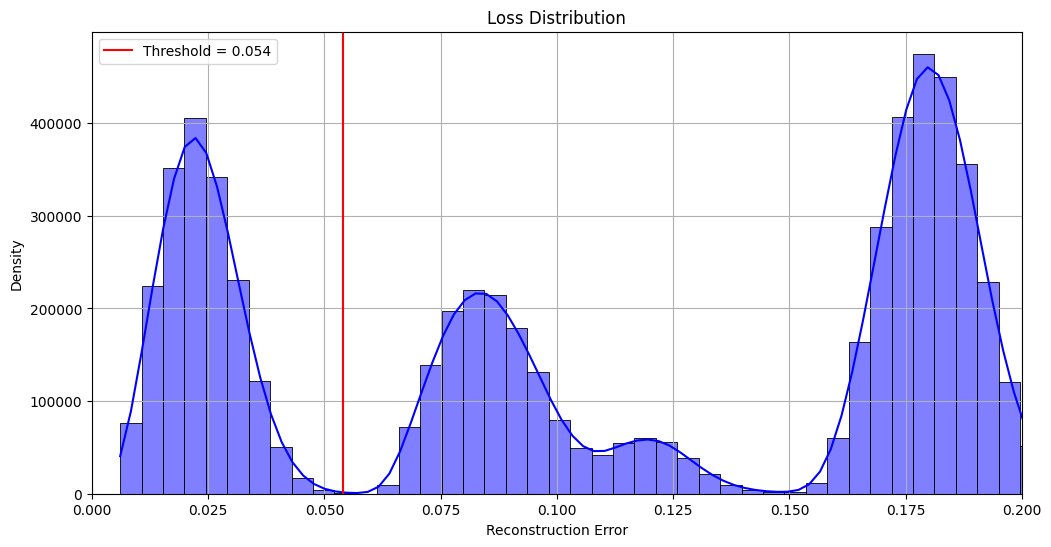

In [383]:
test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    reconstructions = model(test_tensor).cpu().numpy()

reconstruction_errors = np.mean((X_test - reconstructions) ** 2, axis=1)

benign_errors = reconstruction_errors[y_test == 0]
median = np.median(benign_errors)
mad = np.median(np.abs(benign_errors - median))

#   HARDCODED THRESHOLD
threshold = 0.054

print(f"MAD-based threshold: {threshold:.6f}")

plt.figure(figsize=(12, 6))
plt.title("Loss Distribution")

sns.histplot(reconstruction_errors, bins=100, kde=True, color='blue')
plt.axvline(threshold, color='red', linestyle='-', label=f"Threshold = {threshold:.3f}")
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.xlim(0, 0.2)
plt.grid(True)
plt.legend()
plt.savefig("32_16_8_4_results/005DS_100/LossDistribution.png", dpi=300)
plt.show()
plt.close()


In [384]:
y_pred = (reconstruction_errors > threshold).astype(int)

print(f"Threshold: {threshold:.6f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

with open("32_16_8_4_results/005DS_100/ClassificationReport.txt", "w") as f:
    f.write(f"Threshold: {threshold:.6f}\n\n")
    f.write(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

with open("32_16_8_4_results/005DS_100/ConfusionMatrix.txt", "w") as f:
    f.write("Confusion Matrix:\n")
    np.savetxt(f, confusion_matrix(y_test, y_pred), fmt='%d')

Threshold: 0.054000

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.5947    0.7458   3066853
           1     0.7116    1.0000    0.8315   3066853

    accuracy                         0.7973   6133706
   macro avg     0.8558    0.7973    0.7887   6133706
weighted avg     0.8558    0.7973    0.7887   6133706

Confusion Matrix:
[[1823843 1243010]
 [      0 3066853]]


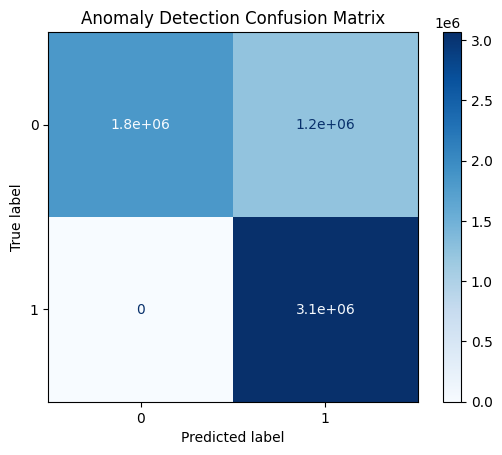

In [385]:
cm = confusion_matrix(y_test, y_pred)
class_names = ['Class 0', 'Class 1']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y):,}'))
plt.savefig("Anomaly_Detection_Confusion_Matrix.png")
plt.title("Anomaly Detection Confusion Matrix")
plt.savefig("32_16_8_4_results/005DS_100/ConfusionMatrixGraph.png", dpi=300)
plt.show()
plt.close()

In [386]:
torch.save(model.state_dict(), "32_16_8_4_results/005DS_100/Model.pth")